I'm currently reading [Dataclysm](http://dataclysm.org/), a book by one of the OkCupid founders, Christian Rudder. He's the one behind the [OkTrends blog](http://blog.okcupid.com/), which gives you a taste of what sort of data analysis the book is about. About halfway through the book, Rudder analyzes essays written by the users about themselves. To find meaning in the data across the different categories (white, black, asian, hispanic), he makes us of [quantile-quantile plots](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot). This struck me as an excellent application of interactive visualization using Bokeh and the Kaggle What's Cooking challenge data, which [I have previously investigated](http://flothesof.github.io/kaggle-whats-cooking-machine-learning.html). 

# Loading the data and counting it 

We will start by loading the data, as usual:

In [1]:
import pandas as pd

In [2]:
df = pd.read_json('train.json')

In [3]:
df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


To produce the sort of plot we want, we need to select one of the categories, say greek cuisine, compute the counts of all ingredients and their ranks and then do the same with the data from all other cuisines. To do this, we'll build ourselves a helper function that provides a count of all ingredients in a part of the dataframe. 

In [4]:
from collections import Counter

def count_ingredients(df):
    """Counts ingredients in given df."""
    
    c = Counter()
    for recipe in df['ingredients']:
        for ingredient in recipe:
            c.update([ingredient])
    
    return c

Let's test this on a single recipe, using the first recipe in the dataset:

In [5]:
count_ingredients(df.iloc[0:1])

Counter({'black olives': 1,
         'feta cheese crumbles': 1,
         'garbanzo beans': 1,
         'garlic': 1,
         'grape tomatoes': 1,
         'pepper': 1,
         'purple onion': 1,
         'romaine lettuce': 1,
         'seasoning': 1})

The input recipe was:

In [6]:
df.iloc[0]['ingredients']

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

So this seems to work. Let's count all greek recipes using this mechanism:

In [7]:
is_greek = df['cuisine'] == 'greek'
greek_counts = count_ingredients(df[is_greek])

In [8]:
[(key, greek_counts[key]) for key in greek_counts.keys()][:10]

[('chopped green bell pepper', 8),
 ('fresh bay leaves', 2),
 ('canned low sodium chicken broth', 5),
 ('cucumber', 187),
 ('thin pizza crust', 2),
 ('cooking spray', 67),
 ('top sirloin steak', 1),
 ('bone in skin on chicken thigh', 1),
 ('granulated garlic', 3),
 ('chopped parsley', 18)]

The last thing we need now is just to use the sorted count results as their ranks. We can do this using the counter's `most_common` method:

In [9]:
greek_counts.most_common(10)

[('salt', 572),
 ('olive oil', 504),
 ('dried oregano', 267),
 ('garlic cloves', 254),
 ('feta cheese crumbles', 252),
 ('extra-virgin olive oil', 229),
 ('fresh lemon juice', 222),
 ('ground black pepper', 221),
 ('garlic', 216),
 ('pepper', 203)]

Actually, we also need a count for all non-greek ingredients. Let's make it here:

In [10]:
non_greek_counts = count_ingredients(df[~is_greek])

# Visualization using Bokeh 

Let's now move on to the qq-plot. To do this interactively, I want to use Bokeh. It turns out that Bokeh can easily plot points as glyphs on a plane and add hover labels ([see here](http://bokeh.pydata.org/en/0.10.0/docs/user_guide/tools.html):


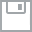
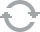
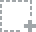
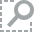
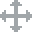
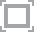
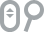
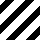
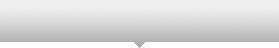
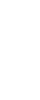
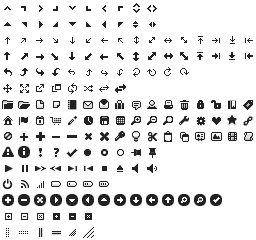
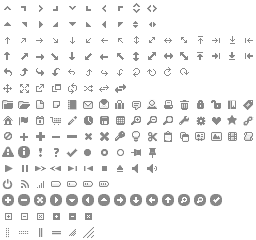
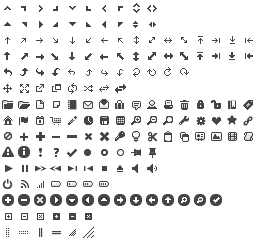
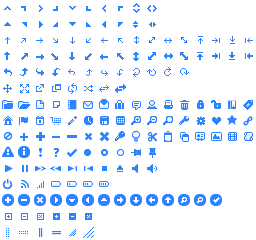
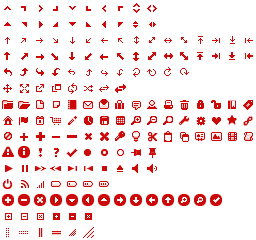
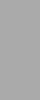
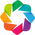
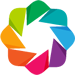

In [11]:
from bokeh.plotting import output_notebook, figure, show
from bokeh.models import HoverTool, BoxSelectTool

output_notebook()

TOOLS = [BoxSelectTool(), HoverTool()]

p = figure(plot_width=600, plot_height=400, title='A test scatter plot with hover labels', tools=TOOLS)

p.circle([1, 2, 3, 4, 5], [2, 5, 8, 2, 7], size=10)

show(p)

Let's write a function that does our qq-plot:

In [12]:
from bokeh.plotting import ColumnDataSource
from bokeh.models import BoxZoomTool, ResetTool

def qqplot(x_list, y_list, specific_cuisine_name):
    """Makes a qqplot using the x_list for abscissa and y_list for ordinate ranks.
    Expects x_list and y_list to be sorted."""
    coords = []
    labels = []
    for y_index, y in enumerate(y_list):
        try:
            x_index = x_list.index(y)
        except ValueError:
            x_index = len(x_list)
        coords.append([x_index, y_index])
        labels.append(y)
    
    x_coords = [(len(x_list) - item[0]) / len(x_list) for item in coords]
    y_coords = [(len(y_list) - item[1]) / len(y_list) for item in coords]
    
    source = ColumnDataSource(
        data=dict(
            x=x_coords,
            y=y_coords,
            desc=labels,
        )
    )
    
    hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <span style="font-size: 17px; font-weight: bold;">@desc</span>
                <span style="font-size: 12px; color: #966;">[$index]</span>
            </div>
            <div>
                <span style="font-size: 12px;">Location</span>
                <span style="font-size: 10px; color: #696;">($x, $y)</span>
            </div>
        </div>
        """
    )
    
    TOOLS = [BoxZoomTool(), ResetTool(), hover]

    p = figure(plot_width=600, plot_height=400, title='QQ plot for {} cuisine'.format(specific_cuisine_name), tools=TOOLS)
    
    p.circle('x', 'y', size=5, source=source)
    p.line([0, 1], [0, 1], line_width=2)
    p.xaxis.axis_label = "rank in all other cuisines"
    p.yaxis.axis_label = "rank in {} cuisine".format(specific_cuisine_name)
    show(p)

Let's now use that function to display ingredients typical for some cuisines and not others:

In [13]:
sorted_greek_ingredients = [item[0] for item in greek_counts.most_common()]

In [14]:
sorted_non_greek_ingredients = [item[0] for item in non_greek_counts.most_common()]

In [15]:
qqplot(sorted_non_greek_ingredients, sorted_greek_ingredients, 'greek')

What's interesting in the above graph is that everything that stands out above the reference line is typical for the specific cuisine. We can distinguish the parts that are very common in greek cuisine and typical (top right above the line) from the ones that are typical of greek cuisine, but uncommon (top left above the line).

Examples include:

- typical and common:
    - kalamata (olives)
    - tahini (sesame paste)
    - pita bread
    - tzatziki
    - bulgur
- typical and not so common:
    - roe
    - tarama
    - myzithra
    - sliced kalamata olives
    - greek-style vinaigrette
    
    
After looking at the data, I can't help but think that this raw data also shows the dataset is not very clean, as a lot of labels on the left could be clustered by humans with similar labels found on the right. For example, the dataset contains "sliced kalamata olives" as well as "kalamata". Both labels refer to the same thing but are not classified in the same way. This is exemplary for how hard it is to work with real world data.

# Visualization of the whole dataset 

Finally, we can produce the same sort of plots for all cuisines:

In [16]:
for cuisine in df.cuisine.unique():
    is_cuisine = df.cuisine == cuisine
    cuisine_counts = count_ingredients(df[is_cuisine])
    other_counts = count_ingredients(df[~is_cuisine])
    sorted_cuisine = [item[0] for item in cuisine_counts.most_common()]
    sorted_other = [item[0] for item in other_counts.most_common()]
    qqplot(sorted_other, sorted_cuisine, cuisine)